# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from os import listdir
from os.path import isfile
from os.path import join as joinpath
import matplotlib.cbook as cbook
import seaborn as sns 

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=20,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


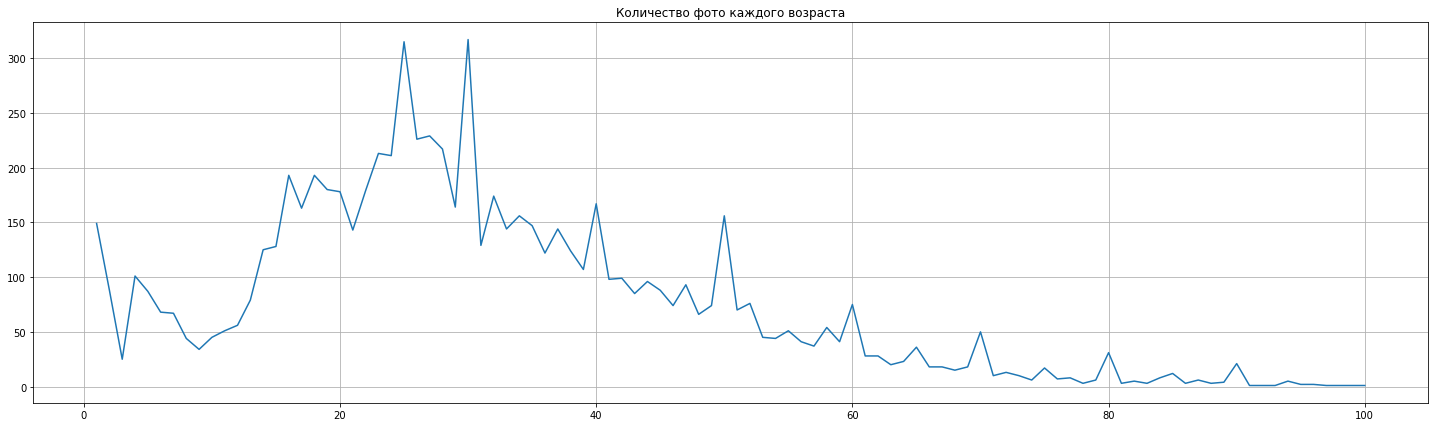

In [4]:
plt.figure(figsize=(25, 7))
plt.plot(labels.groupby("real_age").count())
plt.title('Количество фото каждого возраста')
plt.grid(True)
plt.show()

Видно, что количество фотографий с возрастом снижается к возрасту в 100 лет. Что негативно сказывается на качестве обучения, возможно, лучше было бы объединить возраст в категории.

По графику - видна небольшая бимодальность. Скорее всего, как минимум, замешана ещё одна выборка в данных. Т.е. есть некий признак, который делает гарфик двугорбым). Например школьники здесь и остальные. Т.е. выборка была взята не случайна, а формировалась<br>
Что ещё... пожилых мало.. - это значит плохо обучимся, наверное....<br>
есть младенцы, Действительно есть 100 - тут надо посмотерть на эти фото, что там за люди-то такие...<br>

     file_name  real_age
0   000000.jpg         4
1   000001.jpg        18
2   000002.jpg        80
3   000003.jpg        50
4   000004.jpg        17
5   000005.jpg        27
6   000006.jpg        24
7   000007.jpg        43
8   000008.jpg        26
9   000009.jpg        39
10  000010.jpg        17
11  000011.jpg        51
12  000012.jpg         2
13  000013.jpg         1
14  000014.jpg         6
15  000015.jpg        18
16  000016.jpg        24
17  000017.jpg         5
18  000018.jpg        40
19  000019.jpg        16


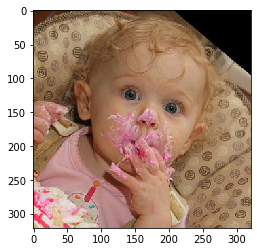

In [5]:
print(labels.head(20))
with cbook.get_sample_data('/datasets/faces/final_files/000013.jpg') as image_file:
    image = plt.imread(image_file)
    plt.imshow(image)

Отметок с возрастом 1 много. Видно на примере 1 фото, что тут действительно фото соответствует возрасту.

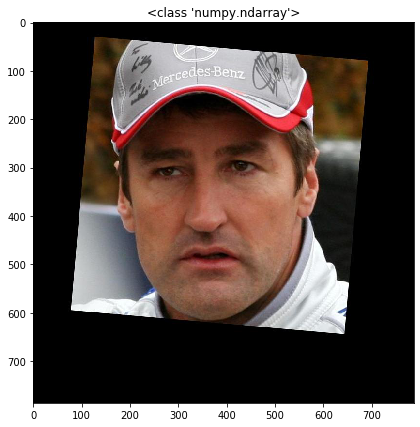

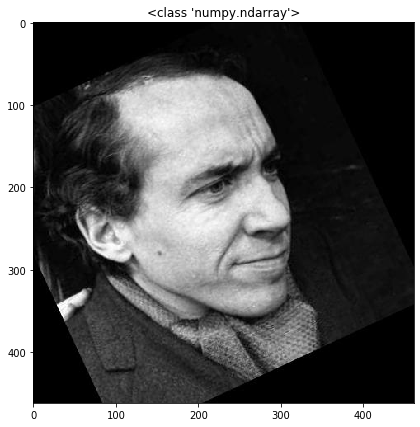

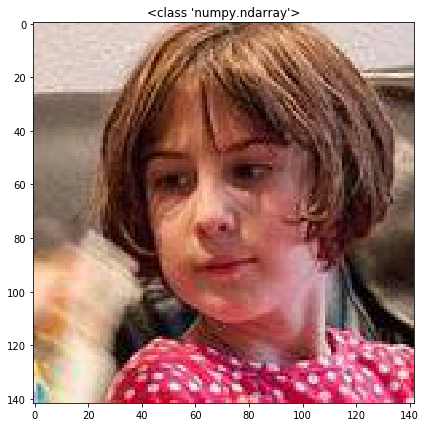

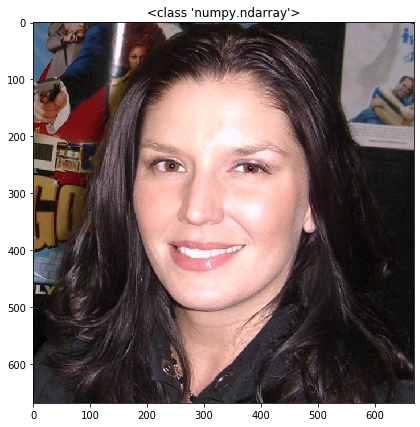

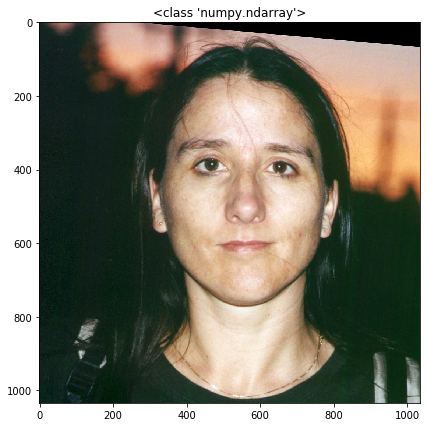

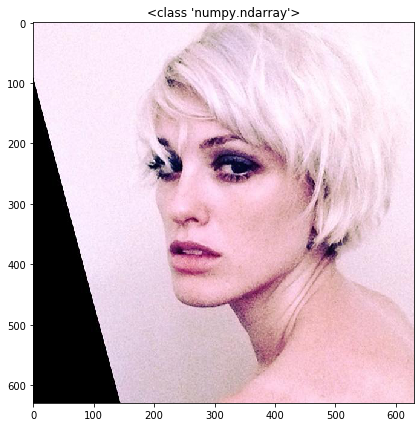

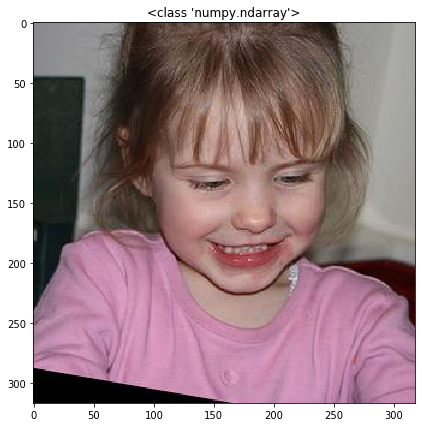

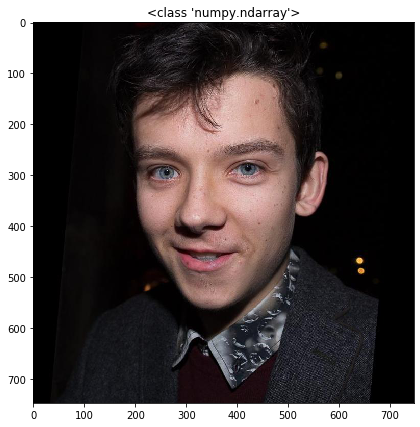

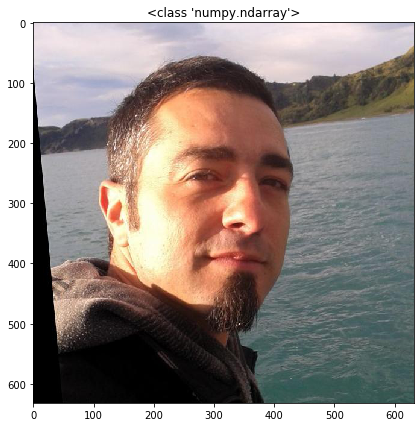

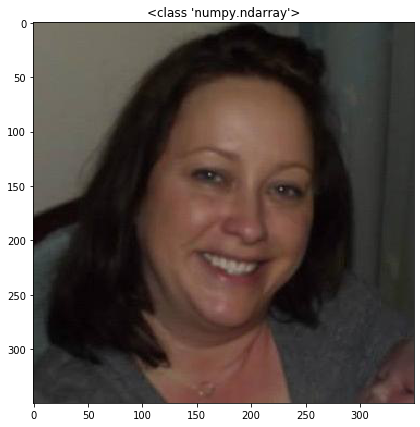

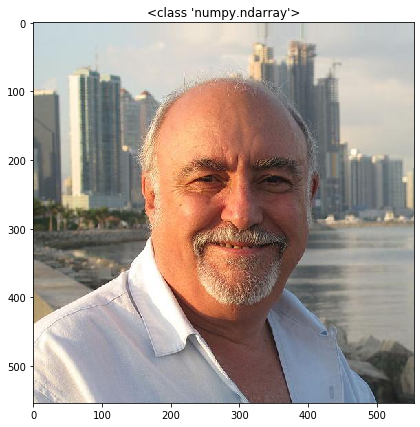

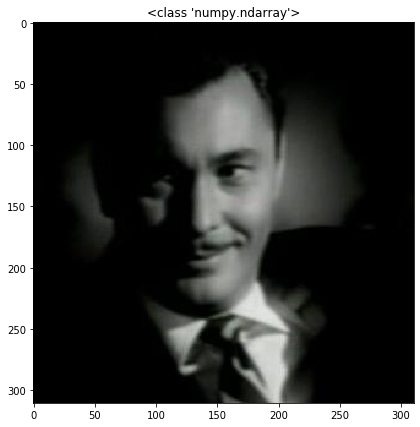

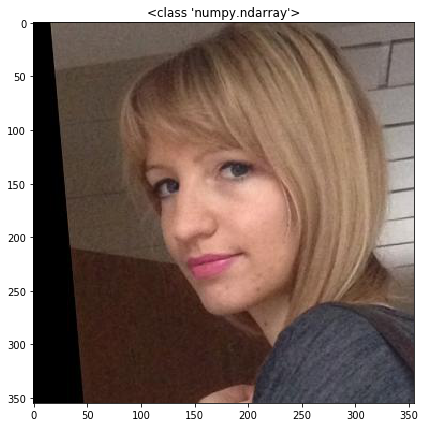

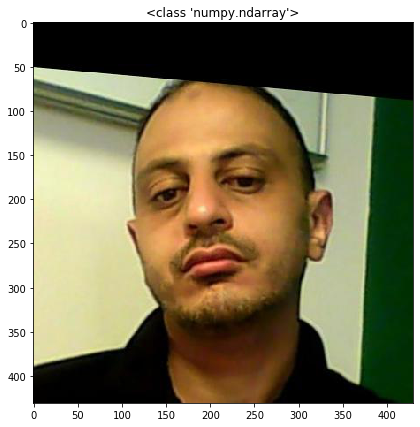

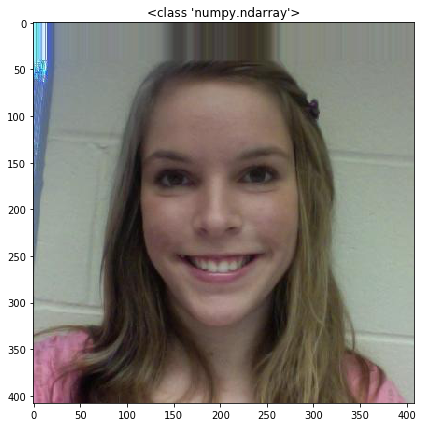

In [6]:
mypath = "content"
k=0
for i in listdir('/datasets/faces/final_files/'):
    if (isfile(joinpath('/datasets/faces/final_files/',i))&(k<15)):
        with cbook.get_sample_data('/datasets/faces/final_files/'+i) as image_file:
            image = plt.imread(image_file)
            fig, ax = plt.subplots()
            ax.imshow(image)
            ax.set_title(type(image))
            fig.set_figwidth(7)    
            fig.set_figheight(7)    
            plt.show()
            k+=1

Видно, что фотографии разного размера, есть цветные и чернобелые, есть фотографии с черными "полями"

1) В датасете есть старые и черно-белые фотографии. Имеет смысл делать аугментацию с тем, чтобы делать фотографию черно-белой в некотором проценте случаев (нету в стандартном наборе). Возможно, стоит подкрутить цветовые каналы или яркость<br>

2) В датасете есть фотогарафи, на которых лица изображены под разными углами к вертикальной оси. Имеет смысл делать аугментацию с rotation_range равным +-15-20 градусов в некотором проценте случаев. Поворачивать можно как само изображение так и объект отдельно от фона<br>

3) В датасете есть фотогарафи, на которых лица изображены в полупрофиль. Имеет смысл делать аугментацию с отражением по горизонтали в некотором проценте случаев<br>

4) В датасете есть фотогарафи с разным разрешением. Имеет смысл делать аугментацию с изменением контрастности изображения в некотором проценте случаев<br>

5) В датасете есть фотогарафи, на которых изображены не лица, а голова и часть туловища (иногда человек послностью). Имеет смысл делать аугментацию с обезкой и масштабированием изображения в некотором проценте случаев, чтобы на фото были только лица примерно одного масштаба<br>

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPool2D, GlobalAveragePooling2D
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import os
 
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv') 
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True,
        vertical_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        subset='training',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
 
    return train_datagen_flow
    
def load_test(path):  
    labels = pd.read_csv(path + 'labels.csv') 
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True,
        vertical_flip=True)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        subset='validation',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
 
    return test_datagen_flow
    
    
def create_model(input_shape):
    optimizer = Adam(lr=0.00001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)                
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model    
    
   
    
def train_model(model, train_data, test_data, batch_size=None, epochs=6,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs, batch_size=batch_size, verbose=2)
    return model

```

```

# < скопируйте результат вывода на экран сюда >

Train for 178 steps, validate for 60 steps
Epoch 1/6
2021-05-01 14:28:03.854847: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-05-01 14:28:08.407011: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 140s - loss: 892.6727 - mae: 25.2141 - val_loss: 971.8747 - val_mae: 26.4323
Epoch 2/6
178/178 - 40s - loss: 274.9137 - mae: 12.9123 - val_loss: 802.1373 - val_mae: 23.4061
Epoch 3/6
178/178 - 40s - loss: 143.3275 - mae: 8.9739 - val_loss: 756.0156 - val_mae: 22.5213
Epoch 4/6
178/178 - 41s - loss: 104.0651 - mae: 7.7044 - val_loss: 218.9263 - val_mae: 11.2284
Epoch 5/6
178/178 - 40s - loss: 81.7947 - mae: 6.8437 - val_loss: 116.0066 - val_mae: 8.2091
Epoch 6/6
178/178 - 40s - loss: 70.3375 - mae: 6.3472 - val_loss: 99.2001 - val_mae: 7.6202
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 98.8739 - mae: 7.6211
Test MAE: 7.6211


# < длинные строки со скачиванием модели можно удалить >

```

## Анализ обученной модели

Обученная модель показала хороший результат MAE: 7.6211, несмотря на малый объем фотографий по высоковозрастному сегменту.

сравнить прогноз и факт. Это позволит посмотреть: а на каких возрастах модель ошибается чаще всего? Каких фото ещё было бы не плохо добавить в выборку для дообучения? Наверняка, там где фоток больше - там точнее, пожет и 2-3 года ошибка.. А на 100-летних - ошибка 20 лет. И тогда в итоге соредняя - как сейчас...  Вообще при любом моделировании - анализ ошибки - это "кландайк" разных интересных открытий может быть.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы